实现LLAMA3

In [117]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

加载模型

In [118]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [119]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [120]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [121]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
prompt_tokens = [128000] + tokenizer.encode(prompt)
#128000 is the <|begin_of_text|> token
print(prompt_tokens)
prompt_tokens = torch.tensor(prompt_tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in prompt_tokens]
print(prompt_split_as_tokens)
prompt_tokens.shape

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


torch.Size([17])

从Token转为Embedding

In [122]:
embedding_layer = torch.nn.Embedding(vocab_size, dim, padding_idx=0)
embedding_layer.weight.data = model["tok_embeddings.weight"]
token_embeddings_unnormalized = embedding_layer(prompt_tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

In [123]:
def rms(tensor,weight=1.0):
    return weight * (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps))

In [124]:
token_embedding = rms(token_embeddings_unnormalized, weight=model["layers.0.attention_norm.weight"])

token_embedding.shape

torch.Size([17, 4096])

In [125]:
model.keys()

dict_keys(['tok_embeddings.weight', 'layers.0.attention.wq.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.feed_forward.w1.weight', 'layers.0.feed_forward.w3.weight', 'layers.0.feed_forward.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.ffn_norm.weight', 'layers.1.attention.wq.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'layers.1.feed_forward.w1.weight', 'layers.1.feed_forward.w3.weight', 'layers.1.feed_forward.w2.weight', 'layers.1.attention_norm.weight', 'layers.1.ffn_norm.weight', 'layers.2.attention.wq.weight', 'layers.2.attention.wk.weight', 'layers.2.attention.wv.weight', 'layers.2.attention.wo.weight', 'layers.2.feed_forward.w1.weight', 'layers.2.feed_forward.w3.weight', 'layers.2.feed_forward.w2.weight', 'layers.2.attention_norm.weight', 'layers.2.ffn_norm.weight', 'layers.3.attention.wq.weight', 'layers.3.attention.wk.weight', 'layers.3.atten

In [126]:
qlayer = model["layers.0.attention.wq.weight"]
head_dim = qlayer.shape[0] // n_heads
qlayer = qlayer.view(n_heads, head_dim, dim)
q0 = qlayer[0]
q0.shape


torch.Size([128, 4096])

In [127]:
q_per_token = torch.matmul(token_embedding, q0.T)
q_per_token.shape

torch.Size([17, 128])

ROPE

In [128]:
q_per_token_rope = q_per_token.float().view(q_per_token.shape[0],-1,2)
q_per_token_rope.shape


torch.Size([17, 64, 2])

In [129]:
zerotooneSplit = torch.tensor(range(64))/64
zerotooneSplit

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [130]:
freqs = 1.0 / (rope_theta ** zerotooneSplit)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

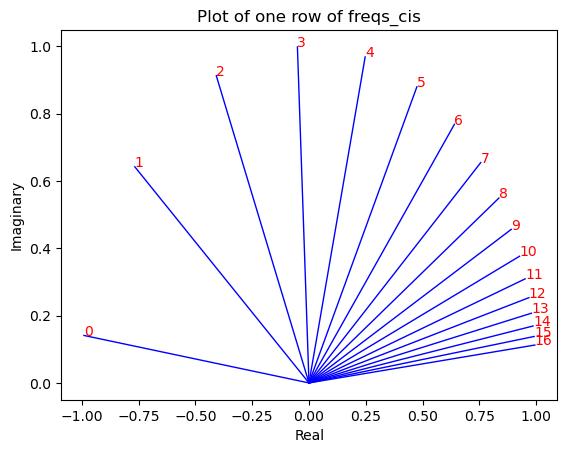

In [131]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_for_each_token

freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [132]:
freqs_for_each_token.shape

torch.Size([17, 64])

In [133]:
value


tensor([-0.9900+1.4112e-01j, -0.7663+6.4249e-01j, -0.4078+9.1309e-01j,
        -0.0509+9.9870e-01j,  0.2471+9.6899e-01j,  0.4747+8.8016e-01j,
         0.6397+7.6862e-01j,  0.7556+6.5498e-01j,  0.8355+5.4950e-01j,
         0.8898+4.5638e-01j,  0.9264+3.7654e-01j,  0.9510+3.0933e-01j,
         0.9674+2.5340e-01j,  0.9783+2.0719e-01j,  0.9856+1.6919e-01j,
         0.9904+1.3805e-01j,  0.9936+1.1258e-01j,  0.9958+9.1774e-02j,
         0.9972+7.4796e-02j,  0.9981+6.0950e-02j,  0.9988+4.9661e-02j,
         0.9992+4.0460e-02j,  0.9995+3.2963e-02j,  0.9996+2.6854e-02j,
         0.9998+2.1876e-02j,  0.9998+1.7821e-02j,  0.9999+1.4518e-02j,
         0.9999+1.1827e-02j,  1.0000+9.6342e-03j,  1.0000+7.8482e-03j,
         1.0000+6.3933e-03j,  1.0000+5.2081e-03j,  1.0000+4.2426e-03j,
         1.0000+3.4561e-03j,  1.0000+2.8154e-03j,  1.0000+2.2935e-03j,
         1.0000+1.8683e-03j,  1.0000+1.5220e-03j,  1.0000+1.2398e-03j,
         1.0000+1.0100e-03j,  1.0000+8.2274e-04j,  1.0000+6.7022e-04j,
      

In [134]:
model["layers.0.attention.wo.weight"].shape

torch.Size([4096, 4096])

In [135]:
q_per_token_rope_complex = torch.view_as_complex(q_per_token_rope)
q_per_token_rope_complex.shape

torch.Size([17, 64])

In [136]:
q_per_token_rope_rotated = q_per_token_rope_complex * freqs_cis
q_per_token_rope_rotated.shape

torch.Size([17, 64])

In [137]:
q_per_token_rope_rotated_real = torch.view_as_real(q_per_token_rope_rotated).view(q_per_token_rope_rotated.shape[0], -1)
q_per_token_rope_rotated_real.shape

torch.Size([17, 128])

Key

In [138]:
klayer = model["layers.0.attention.wk.weight"]
head_dim = klayer.shape[0] // n_kv_heads
klayer = klayer.view(n_kv_heads, head_dim, dim)
k0 = klayer[0]
print(k0.shape)
k_per_token = torch.matmul(token_embedding, k0.T)
print(k_per_token.shape)
k_per_token_rope = k_per_token.float().view(k_per_token.shape[0],-1,2)
k_per_token_rope.shape


torch.Size([128, 4096])
torch.Size([17, 128])


torch.Size([17, 64, 2])

In [139]:
klayer.shape

torch.Size([8, 128, 4096])

In [140]:
k_per_token_rope.shape

torch.Size([17, 64, 2])

In [141]:
k_per_token_rope_complex = torch.view_as_complex(k_per_token_rope)
print(k_per_token_rope_complex.shape)
k_per_token_rope_rotated = k_per_token_rope_complex * freqs_cis
print(k_per_token_rope_rotated.shape)
k_per_token_rope_rotated_real = torch.view_as_real(k_per_token_rope_rotated).view(k_per_token_rope_rotated.shape[0], -1)
k_per_token_rope_rotated_real.shape

torch.Size([17, 64])
torch.Size([17, 64])


torch.Size([17, 128])

Q K 相乘

In [ ]:
q_k = torch.matmul(q_per_token_rope_rotated_real, k_per_token_rope_rotated_real.T)/(head_dim)**0.5
q_k.shape

torch.Size([17, 17])

Mask q k Code

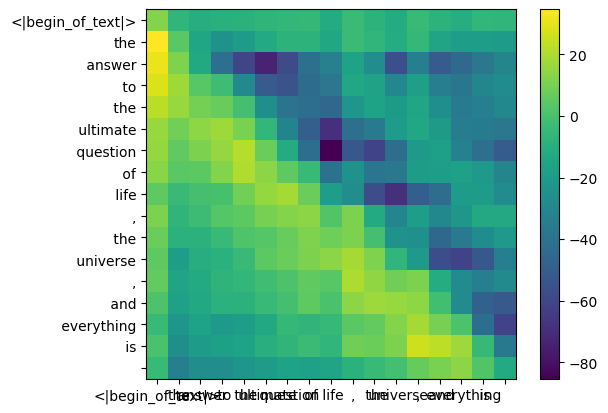

In [143]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(q_k)

In [144]:
mask = torch.full((len(prompt_tokens), len(prompt_tokens)), float("-inf"), device=prompt_tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

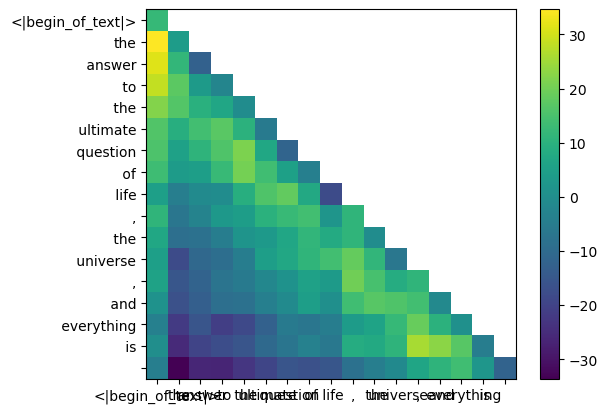

In [145]:
qk_per_token_after_masking = q_k + mask
display_qk_heatmap(qk_per_token_after_masking)

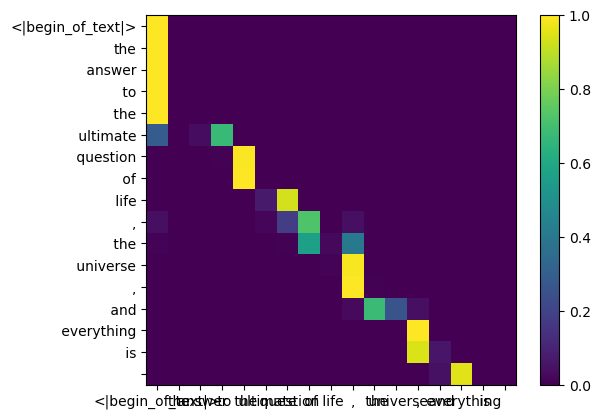

In [146]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

Value

In [147]:
value_layer = model["layers.0.attention.wv.weight"]
value_layer = value_layer.view(n_kv_heads, -1, dim)
value_layer.shape

torch.Size([8, 128, 4096])

In [148]:
v_0 = value_layer[0]
v_0.shape

torch.Size([128, 4096])

In [149]:
v_per_token = torch.matmul(token_embedding, v_0.T)
print(v_per_token.shape)

torch.Size([17, 128])


QKV Attention

In [150]:
qkv = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv.shape

torch.Size([17, 128])

MultiHead

In [ ]:
qkv_array = []

for head in range(n_heads):
    q_i = qlayer[head]
    k_i = klayer[head // 4]
    v_i = value_layer[head // 4]

    q_embedding = torch.matmul(token_embedding, q_i.T)
    k_embedding = torch.matmul(token_embedding, k_i.T)
    v_embedding = torch.matmul(token_embedding, v_i.T)

    q_embedding_rope = q_embedding.float().view(q_embedding.shape[0], -1, 2)
    k_embedding_rope = k_embedding.float().view(k_embedding.shape[0], -1, 2)

    q_embedding_rope_complex = torch.view_as_complex(q_embedding_rope)
    k_embedding_rope_complex = torch.view_as_complex(k_embedding_rope)
    q_embedding_rope_rotated = q_embedding_rope_complex * freqs_cis
    k_embedding_rope_rotated = k_embedding_rope_complex * freqs_cis
    q_embedding_rope_rotated_real = torch.view_as_real(q_embedding_rope_rotated).view(q_embedding_rope_rotated.shape[0], -1)
    k_embedding_rope_rotated_real = torch.view_as_real(k_embedding_rope_rotated).view(k_embedding_rope_rotated.shape[0], -1)
    q_k = torch.matmul(q_embedding_rope_rotated_real, k_embedding_rope_rotated_real.T)/(128)**0.5
    mask = torch.full((len(prompt_tokens), len(prompt_tokens)), float("-inf"), device=prompt_tokens.device)
    mask = torch.triu(mask, diagonal=1)
    q_k_after_masking = q_k + mask
    q_k_after_masking_after_softmax = torch.nn.functional.softmax(q_k_after_masking, dim=1).to(torch.bfloat16)

    qkv = torch.matmul(q_k_after_masking_after_softmax, v_embedding)
    qkv_array.append(qkv)
qkv_output = torch.cat(qkv_array, dim=-1)
qkv_output.shape


torch.Size([17, 4096])

Attention Output

In [152]:
o_layer = model["layers.0.attention.wo.weight"]
o_layer.shape

torch.Size([4096, 4096])

In [153]:
output = torch.matmul(qkv_output, o_layer.T)
output.shape

torch.Size([17, 4096])

In [154]:
token_embeddings_output = token_embeddings_unnormalized + output
token_embeddings_output.shape

torch.Size([17, 4096])

Normalize

In [155]:
token_embeddings_output_normalized = rms(token_embeddings_output, weight=model["layers.0.ffn_norm.weight"])
token_embeddings_output_normalized.shape

torch.Size([17, 4096])

In [156]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]

In [157]:
token_embeddings_output_ffn = torch.matmul((torch.functional.F.silu(torch.matmul(token_embeddings_output_normalized, w1.T)) * torch.matmul(token_embeddings_output_normalized, w3.T)),w2.T)
token_embeddings_output_ffn.shape

torch.Size([17, 4096])

In [158]:
layer_output = token_embeddings_output + token_embeddings_output_ffn
layer_output.shape

torch.Size([17, 4096])

All Layer!

In [168]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    layer_embedding_norm = rms(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    qkv_array_i_layer = []
    qlayer = model[f"layers.{layer}.attention.wq.weight"]
    qlayer = qlayer.view(n_heads, -1, dim)
    klayer = model[f"layers.{layer}.attention.wk.weight"] 
    klayer = klayer.view(n_kv_heads, -1, dim)
    vlayer = model[f"layers.{layer}.attention.wv.weight"]
    vlayer = vlayer.view(n_kv_heads, -1, dim)
    olayer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_i = qlayer[head]
        k_i = klayer[head // 4]
        v_i = vlayer[head // 4]

        q_embedding = torch.matmul(layer_embedding_norm, q_i.T)
        k_embedding = torch.matmul(layer_embedding_norm, k_i.T)
        v_embedding = torch.matmul(layer_embedding_norm, v_i.T)

        q_embedding_rope = q_embedding.float().view(q_embedding.shape[0], -1, 2)
        k_embedding_rope = k_embedding.float().view(k_embedding.shape[0], -1, 2)

        q_embedding_rope_complex = torch.view_as_complex(q_embedding_rope)
        k_embedding_rope_complex = torch.view_as_complex(k_embedding_rope)
        q_embedding_rope_rotated = q_embedding_rope_complex * freqs_cis
        k_embedding_rope_rotated = k_embedding_rope_complex * freqs_cis
        q_embedding_rope_rotated_real = torch.view_as_real(q_embedding_rope_rotated).view(q_embedding_rope_rotated.shape[0], -1)
        k_embedding_rope_rotated_real = torch.view_as_real(k_embedding_rope_rotated).view(k_embedding_rope_rotated.shape[0], -1)
        q_k = torch.matmul(q_embedding_rope_rotated_real, k_embedding_rope_rotated_real.T)/(128)**0.5
        mask = torch.full((len(prompt_tokens), len(prompt_tokens)), float("-inf"), device=prompt_tokens.device)
        mask = torch.triu(mask, diagonal=1)
        q_k_after_masking = q_k + mask
        q_k_after_masking_after_softmax = torch.nn.functional.softmax(q_k_after_masking, dim=1).to(torch.bfloat16)

        qkv = torch.matmul(q_k_after_masking_after_softmax, v_embedding)
        qkv_array_i_layer.append(qkv)
    qkv_output_layer = torch.cat(qkv_array_i_layer, dim=-1)
    attention_output = torch.matmul(qkv_output_layer, olayer.T)
    attention_output_editted = final_embedding + attention_output
    attention_output_normalized = rms(attention_output_editted, weight=model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    ffn_output = torch.matmul((torch.functional.F.silu(torch.matmul(attention_output_normalized, w1.T)) * torch.matmul(attention_output_normalized, w3.T)), w2.T)
    final_embedding = attention_output_editted + ffn_output

final_embedding.shape
    

torch.Size([17, 4096])

In [169]:
final_embedding = rms(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

In [170]:
final_embedding

tensor([[ 4.1875, -0.2451, -1.8281,  ..., -2.8438,  1.4062,  0.1089],
        [-2.4844, -0.2793, -2.1094,  ..., -0.7695, -0.7344,  0.3125],
        [ 1.5391, -1.9062,  3.8906,  ...,  1.5703,  1.8281, -0.3301],
        ...,
        [-1.3984, -0.5703,  1.4062,  ..., -0.7734,  1.4922, -0.1875],
        [-2.8906, -1.1406,  0.5391,  ...,  0.2051,  1.6484, -0.0544],
        [-2.7031, -2.5781,  2.8906,  ...,  0.5977,  4.6875,  0.3965]],
       dtype=torch.bfloat16, grad_fn=<MulBackward0>)

In [171]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [172]:
logits

tensor([ 1.9531, -1.3203,  1.2578,  ..., -3.3594, -3.3594, -3.3594],
       dtype=torch.bfloat16, grad_fn=<SqueezeBackward4>)

In [173]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [174]:
tokenizer.decode([next_token.item()])

'42'